
This project aims to determine which features are deemed valuable by journalists to be a successful football player in Serie A.  
  
To accomplish this, we're using two data sources:
1. [FBref.com](https://fbref.com) – An online service collecting player-level objective stats.
2. [Fantacalcio.it](www.fantacalcio.it) – A [fantasy sport](https://en.wikipedia.org/wiki/Fantasy_sport) website measuring the players' performance in a subjective manner.

By combining these datasets, one can quantify which metrics affect the journalists' judgment when they assign their scores to players.  
To do so, an inference model is built to perform [regression analysis](https://en.wikipedia.org/wiki/Regression_analysis). The model measures each variable's impact on the output when the others are kept constant.  
In our case, the columns from data source (1) are used as independent variables `x`, while the scores in (2) represent the dependent variable `y`.
  
The results of this analysis can be helpful in many ways, including:
- Gauging the impact a new player (from a foreign league, the youth system, or lower tiers) could have in the Italian top tier.
- Learning where and how a player could improve their performance.
- Learning potential biases in how players are judged.

In [ ]:
import os

from google.colab import drive
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm

In [ ]:
sns.set_context("paper")

# Load Data

The two data sources employed in this analysis measure a player's performance in different ways.

1. **FBref** provides a set of stats corresponding to what a player or their team have done on the pitch and how often. This gives us an *objective* perspective of the game.  
2. **Fantacalcio** is a collection of *subjective* scores representing the players' performance, according to journalists.
  
In both cases, the datasets record each player's average performance for an entire season, from the 2017/2018 campaign to 2021/2022.  
  
A couple of notes:
- In October 2022, [FBref changed their data provider](https://www.sports-reference.com/blog/2022/10/fbref-leagues-%F0%9F%87%B5%F0%9F%87%B9-leagues-%F0%9F%87%A7%F0%9F%87%B7-leagues-%F0%9F%87%B2%F0%9F%87%BD-expanded-womens-and-mens-data-new-data-partner/), which means that some features are calculated differently or no longer available. The datasets used in this project were gathered before the change.
- The datasets were filtered to only include players with at least 10 games played.

In [ ]:
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
FOLDER_DATA = '/content/drive/MyDrive/fantacalcio/performance_vs_votes/data'
FILENAME_DATASET_GK = 'df_dataset_gk.csv'
FILENAME_DATASET_NON_GK = 'df_dataset_non_gk.csv'
FILENAME_METADATA_GK = 'df_metadata_gk.csv'
FILENAME_METADATA_NON_GK = 'df_metadata_non_gk.csv'

In [ ]:
# Load datasets
df_dataset_gk = \
  pd.read_csv(os.path.join(FOLDER_DATA, FILENAME_DATASET_GK))
df_dataset_non_gk = \
  pd.read_csv(os.path.join(FOLDER_DATA, FILENAME_DATASET_NON_GK))

df_metadata_gk = \
  pd.read_csv(os.path.join(FOLDER_DATA, FILENAME_METADATA_GK))
df_metadata_non_gk = \
  pd.read_csv(os.path.join(FOLDER_DATA, FILENAME_METADATA_NON_GK))

In [ ]:
# Separate x and y
cols_y = ['AvgScore']
cols_gk_x = [col for col in df_dataset_gk.columns if col not in cols_y]
cols_non_gk_x = [col for col in df_dataset_non_gk.columns if col not in cols_y]

y_gk = df_dataset_gk[cols_y[0]].values
x_gk = df_dataset_gk[[col for col in df_dataset_gk.columns if col not in cols_y]].values

y_non_gk = df_dataset_non_gk[cols_y[0]].values
x_non_gk = df_dataset_non_gk[[col for col in df_dataset_non_gk.columns if col not in cols_y]].values

In [ ]:
# Extract roles
list_roles = sorted(df_metadata_non_gk['Pos'].unique())
list_roles = list(set([r[0] for r in list_roles]))  # ('D', 'M', 'F')

# Feature Selection

In this section, the data processing phase begins.  
The number of independent variables is relatively high, so we adopt several techniques to select the most relevant attributes.  
An important thing to notice is that all datasets (and results) are segmented based on the main positions:
- Goalkeeper (GK)
- Defender (D)
- Midfielder (M)
- Forward (F)

In [ ]:
def select_features(x, y, clf, direction='forward', k=None, tol=0.001):
  """
  Perform Sequential Feature Selection on the dataset.
  See https://tinyurl.com/yckrn954

  Args
      x (array): independent variables
      y (array): dependent variables
      clf (sklearn model): linear regression model used to select features
      direction (str): either 'forward' or 'backward'
      k (str or int): if 'auto' then `tol` will be used, otherwise represents
                      the maximum number of features
      tol (float): tolerance factor; only used when `k` is None

  Returns
      sfs (SequentialFeatureSelector): transformer trained on the input data
  """
  if k is None:
    sfs = SequentialFeatureSelector(clf,
                                    direction=direction,
                                    n_features_to_select='auto',
                                    tol=tol)
  elif k > 0:
    sfs = SequentialFeatureSelector(clf,
                                    direction=direction,
                                    n_features_to_select=k)
  sfs.fit(x, y)
  return sfs


def calculate_vif(df, col_y=None):
  """
  Calculate VIF.

  Args
      df (pandas.DataFrame): input dataset
      col_y (str): name of the column containing dependent values

  Returns
      df_vif (pandas.DataFrame): VIF values
  """
  if col_y is not None:
    df = df[[col for col in df.columns if col != col_y]]

  df_vif = pd.DataFrame()
  df_vif['col'] = df.columns
  df_vif['vif'] = [variance_inflation_factor(df.values, i)
                   for i in range(df.shape[1])]
  return df_vif

## Correlation between `x` and `y`

First, we find what individual variables have the highest correlation with the subjective output scores.

In [ ]:
# Find x variables with highest correlation with y
dict_r2_cols = {}
corrs_gk = df_dataset_gk.corr(method='spearman').loc[cols_y[0]]
dict_r2_cols['GK'] = \
  [col for col in corrs_gk[np.abs(corrs_gk) >= 0.1].index if col not in cols_y]

for role in list_roles:
  df_curr = df_dataset_non_gk[df_metadata_non_gk['Pos'].str.startswith(role)]
  corrs_non_gk = df_curr.corr(method='spearman').loc[cols_y[0]]
  dict_r2_cols[role] = \
    [col for col in corrs_non_gk[(corrs_non_gk < -0.1) |
     (corrs_non_gk >= +0.5)].index
     if col not in cols_y]

### Visualize Correlation via Scatter Plot

In [ ]:
role = 'GK'
season = '2019-2020'
x_col = 'PSxG+/-'
z_col = '90s'

df_curr = df_dataset_gk
df_curr = df_curr[df_metadata_gk['season'] == season]

df_curr['Squad'] = df_metadata_gk.loc[df_metadata_gk['Pos'].str.startswith(role), 'Squad']
df_curr['Name'] = \
  df_metadata_gk.loc[df_metadata_gk['Pos'].str.startswith(role), 'Name']
list_squads = sorted(df_curr['Squad'].unique())

fig = px.scatter(df_curr,
                 x=x_col, y=cols_y[0], size=z_col,
                 text=df_curr['Name'],
                 color='Squad',
                 category_orders={'Squad': list_squads},
                 title=role + " – Season " + season,
                 color_discrete_sequence=px.colors.qualitative.Light24,
                 width=800, height=800)
fig.update_layout(font=dict(size=10))
fig.show()

<ipython-input-111-67cab7611ae0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-111-67cab7611ae0>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
role = 'D'
season = '2019-2020'
x_col = '+/-90'
z_col = '90s'

df_curr = df_dataset_non_gk[df_metadata_non_gk['Pos'].str.startswith(role)]
df_curr = df_curr[df_metadata_non_gk['season'] == season]

df_curr['Squad'] = df_metadata_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), 'Squad']
df_curr['Name'] = \
  df_metadata_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), 'Name']
list_squads = sorted(df_curr['Squad'].unique())

fig = px.scatter(df_curr,
                 x=x_col, y=cols_y[0], size=z_col,
                 text=df_curr['Name'],
                 color='Squad',
                 category_orders={'Squad': list_squads},
                 title=role + " – Season " + season,
                 color_discrete_sequence=px.colors.qualitative.Light24,
                 width=800, height=800)
fig.update_layout(font=dict(size=10))
fig.show()

<ipython-input-110-fae1e8a151ad>:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
role = 'M'
season = '2019-2020'
x_col = '+/-90'
z_col = '90s'

df_curr = df_dataset_non_gk[df_metadata_non_gk['Pos'].str.startswith(role)]
df_curr = df_curr[df_metadata_non_gk['season'] == season]

df_curr['Squad'] = df_metadata_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), 'Squad']
df_curr['Name'] = \
  df_metadata_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), 'Name']
list_squads = sorted(df_curr['Squad'].unique())

fig = px.scatter(df_curr,
                 x=x_col, y=cols_y[0], size=z_col,
                 text=df_curr['Name'],
                 color='Squad',
                 category_orders={'Squad': list_squads},
                 title=role + " – Season " + season,
                 color_discrete_sequence=px.colors.qualitative.Light24,
                 width=800, height=800)
fig.update_layout(font=dict(size=10))
fig.show()

<ipython-input-109-e7bf45b475af>:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
role = 'F'
season = '2019-2020'
x_col = 'G/SoT'
z_col = '90s'

df_curr = df_dataset_non_gk[df_metadata_non_gk['Pos'].str.startswith(role)]
df_curr = df_curr[df_metadata_non_gk['season'] == season]

df_curr['Squad'] = df_metadata_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), 'Squad']
df_curr['Name'] = \
  df_metadata_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), 'Name']
list_squads = sorted(df_curr['Squad'].unique())

fig = px.scatter(df_curr,
                 x=x_col, y=cols_y[0], size=z_col,
                 text=df_curr['Name'],
                 color='Squad',
                 category_orders={'Squad': list_squads},
                 title=role + " – Season " + season,
                 color_discrete_sequence=px.colors.qualitative.Light24,
                 width=800, height=800)
fig.update_layout(font=dict(size=10))
fig.show()

<ipython-input-108-90841d74dc5e>:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
role = 'F'
season = '2019-2020'
x_col = '+/-90'
z_col = '90s'

df_curr = df_dataset_non_gk[df_metadata_non_gk['Pos'].str.startswith(role)]
df_curr = df_curr[df_metadata_non_gk['season'] == season]

df_curr['Squad'] = df_metadata_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), 'Squad']
df_curr['Name'] = \
  df_metadata_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), 'Name']
list_squads = sorted(df_curr['Squad'].unique())

fig = px.scatter(df_curr,
                 x=x_col, y=cols_y[0], size=z_col,
                 text=df_curr['Name'],
                 color='Squad',
                 category_orders={'Squad': list_squads},
                 title=role + " – Season " + season,
                 color_discrete_sequence=px.colors.qualitative.Light24,
                 width=800, height=800)
fig.update_layout(font=dict(size=10))
fig.show()

<ipython-input-112-3b389c28d2e0>:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



## Sequential Feature Selection

For each position, we apply [Sequential Feature Selection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to keep the most relevant variables.

In [ ]:
# Select features

clf = LinearRegression()
dict_sfs = {}

# GK
sfs_gk = select_features(x_gk, y_gk, clf, direction='forward', k=20)
# sfs_gk = select_features(x_gk, y_gk, clf, direction='forward', k=None, tol=0.001)
dict_sfs['GK'] = sfs_gk

# Non-GK roles
for role in list_roles:
  print(role, end='\r')
  x = x_non_gk[(df_metadata_non_gk['Pos'].str.startswith(role)).values, :]
  y = y_non_gk[(df_metadata_non_gk['Pos'].str.startswith(role)).values]
  sfs_curr = select_features(x, y, clf, direction='forward', k=40)
  # sfs_curr = select_features(x, y, clf, direction='forward', k=None, tol=0.001)
  dict_sfs[role] = sfs_curr

# Print the list of features selected by the algorithm for each role
for role in dict_sfs.keys():
  print(role)
  sfs = dict_sfs[role]
  if role == 'GK':
    print(sfs.get_feature_names_out(input_features=cols_gk_x))
  else:
    print(sfs.get_feature_names_out(input_features=cols_non_gk_x))
  print()

GK
['PKA' 'FK' 'CK' 'OG' 'PSxG+/-' 'Cmp%' 'Thr' 'AvgLen' 'Stp' 'Stp%'
 '#OPA/90' 'AvgDist' 'Save%' 'W' 'D' 'CS' 'CS%' 'PKatt' 'PKsv' 'PKm']

D
['Age' '90s' 'Tkl' 'TklW' 'Att' 'Tkl%' 'Past' 'ShSv' 'Pass' 'Int'
 'Tkl+Int' 'Clr' 'Err' 'PassDead' 'Drib' 'CrdY' 'CrdR' 'Off' 'Crs' 'PKwon'
 'OG' 'Recov' 'Won' 'Str' 'Low' 'Head' 'Min' 'Mn/MP' 'Min%' 'unSub' 'onGA'
 '+/-90' 'On-Off' 'xG+/-' 'Mn/Sub' 'Gls' 'SoT%' 'PKatt' 'G+A' 'G+A-PK']

F
['Def 3rd' 'Past' 'Succ' 'Pass' 'Int' 'SCA90' 'PassLive' 'Fld' 'GCA'
 'CrdR' 'PKcon' 'Recov' 'Lost' 'FK' 'Out' 'Ground' 'Right' 'Head' 'Cmp%'
 'xA' 'CrsPA' 'Min' 'Subs' 'PPM' '+/-90' 'On-Off' 'onxGA' 'xG+/-'
 'Mn/Start' 'Def Pen' '#Pl' 'Targ' 'Rec%' 'SoT' 'SoT%' 'G/SoT' 'PK'
 'PKatt' 'G+A' 'G+A-PK']

M
['Age' 'Att 3rd' 'Tkl%' 'Sh' 'Clr' 'SCA90' 'PassDead' 'Drib' 'Def' 'GCA'
 'CrdR' 'Crs' 'OG' 'Recov' 'Lost' 'FK' 'TB' 'CK' 'In' 'Left' 'Head'
 'Other' 'A-xA' 'KP' 'Mn/MP' 'Subs' 'unSub' 'PPM' 'onGA' '+/-90' 'On-Off'
 'onxGA' '#Pl' 'CPA' 'Dis' 'Gls' 'npxG' 'npxG/S

## VIF

Once we have selected the most relevant features, we can check the quality of this selection. A way to do so is by using [Variance Inflation Factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) (VIF). It quantifies the severity of multicollinearity, i.e. how much the independent variables are correlated with each other.  

Usually, variables with a VIF greater than 5 are considered problematic and removed from the dataset.

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Text(0.5, 0.98, 'VIF')

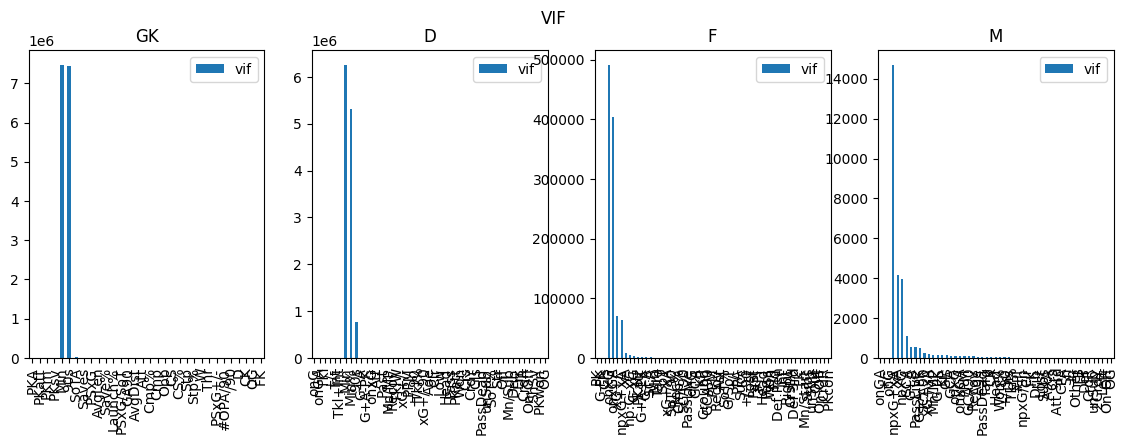

In [ ]:
# Calculate VIF
dict_vif = {}
for role in dict_sfs.keys():
  if role == 'GK':
    df_vif_gk = df_dataset_gk.drop(cols_y[0], axis=1)
    df_vif_gk[cols_y[0]] = y_gk
    cols_gk_sfs = [col for col in dict_sfs['GK'].get_support()] + [False]
    df_vif_gk = df_vif_gk.iloc[:, cols_gk_sfs]
    for col in dict_r2_cols[role]:
      if col not in df_vif_gk.columns:
        df_vif_gk[col] = df_dataset_gk[col]
    vif_gk = calculate_vif(df_vif_gk, col_y=cols_y[0])
    dict_vif[role] = vif_gk
  else:
    df_dataset_role = \
      df_dataset_non_gk[df_metadata_non_gk['Pos'].str.startswith(role)]
    curr_y_non_gk = df_dataset_non_gk[cols_y[0]]
    df_vif_non_gk = df_dataset_role.copy().drop(cols_y[0], axis=1)
    df_vif_non_gk[cols_y[0]] = curr_y_non_gk
    cols_non_gk_sfs = [col for col in dict_sfs[role].get_support()] + [False]
    df_vif_non_gk = df_vif_non_gk.iloc[:, cols_non_gk_sfs]
    for col in dict_r2_cols[role]:
      if col not in df_vif_non_gk.columns:
        df_vif_non_gk[col] = df_dataset_role[col]
    vif_non_gk = calculate_vif(df_vif_non_gk, col_y=cols_y[0])
    dict_vif[role] = vif_non_gk


    # curr_y_non_gk = \
    #   df_dataset_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role),
    #                         cols_y[0]]
    # df_vif_non_gk = \
    #   df_dataset_non_gk[df_metadata_non_gk['Pos'].str.startswith(role)]
    # df_vif_non_gk = df_vif_non_gk.drop(cols_y[0], axis=1)
    # df_vif_non_gk[cols_y[0]] = curr_y_non_gk
    # cols_non_gk_sfs = [col for col in dict_sfs[role].get_support()] + [False]
    # df_vif_non_gk = df_vif_non_gk.iloc[:, cols_non_gk_sfs]
    # vif_non_gk = calculate_vif(df_vif_non_gk, col_y=cols_y[0])
    # dict_vif[role] = vif_non_gk

# Visualize VIF
num_roles = len(dict_vif.keys())
fig, axes = plt.subplots(nrows=1, ncols=num_roles, figsize=(14, 4))
for i_role, role in enumerate(dict_vif.keys()):
  # print(role)
  plt.subplot(1, num_roles, i_role + 1)
  dict_vif[role].sort_values('vif', ascending=False)\
    .plot(kind='bar', x='col', y='vif', ax=axes[i_role], title=role)
  plt.xlabel("")
plt.suptitle("VIF")

For each role, remove variables with high VIF, i.e. > 5.

Text(0.5, 0.98, 'GK')

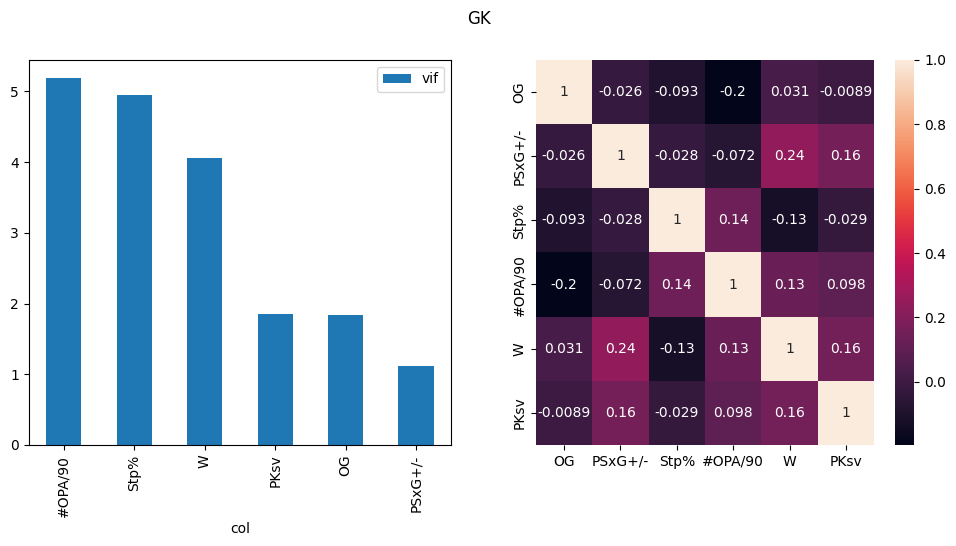

In [ ]:
role = 'GK'

df_vif_gk = df_dataset_gk.drop(cols_y[0], axis=1)
df_vif_gk[cols_y[0]] = y_gk
cols_gk_sfs = [col for col in dict_sfs['GK'].get_support()] + [False]
df_vif_gk = df_vif_gk.iloc[:, cols_gk_sfs]
# cols_vif_gk_ko = ['PKA', 'PKatt', 'PKm', 'AvgDist', 'AvgLen', 'Save%', 'CS',
#                   'Cmp%', 'Thr', 'Stp', 'W', 'D', 'CK', 'CS%']
cols_vif_gk_ko = ['PKA', 'PKatt', 'PKm', 'AvgDist', 'AvgLen', 'Save%', 'CS',
                  'Thr', 'Stp', 'D', 'CK', 'FK', 'Cmp%', 'CS%']
df_vif_gk = df_vif_gk.drop(cols_vif_gk_ko, axis=1)
vif_gk = calculate_vif(df_vif_gk, col_y=cols_y[0])

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
vif_gk.sort_values('vif', ascending=False)\
  .plot(kind='bar', x='col', y='vif', ax=axes[0])
corrs_gk = df_vif_gk.corr(method='spearman')
sns.heatmap(corrs_gk, annot=True, ax=axes[1])
plt.suptitle(role)

In [ ]:
dict_vif_non_gk = {}

Text(0.5, 0.98, 'D')

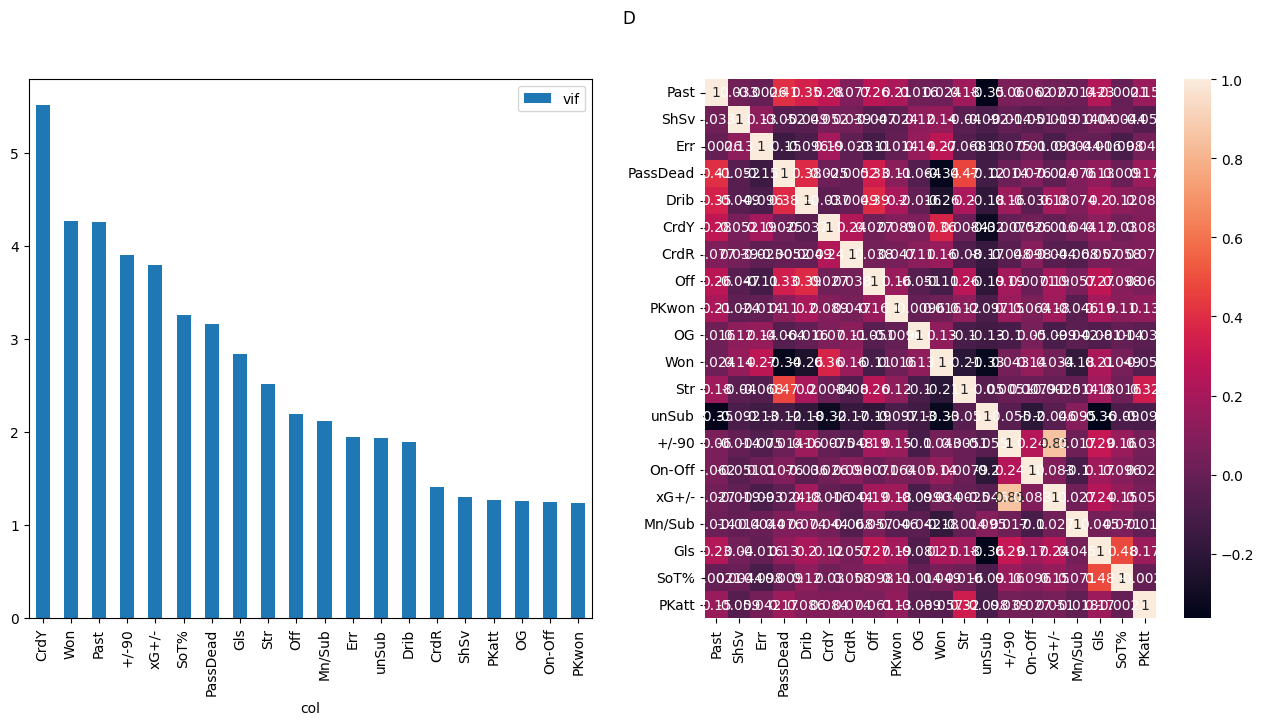

In [ ]:
role = 'D'
curr_y_non_gk = df_dataset_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), cols_y[0]]

df_vif_non_gk = df_dataset_non_gk[df_metadata_non_gk['Pos'].str.startswith(role)]
df_vif_non_gk = df_vif_non_gk.drop(cols_y[0], axis=1)
df_vif_non_gk[cols_y[0]] = curr_y_non_gk
cols_non_gk_sfs = [col for col in dict_sfs[role].get_support()] + [False]
df_vif_non_gk = df_vif_non_gk.iloc[:, cols_non_gk_sfs]
cols_vif_non_gk_ko = ['Tkl', 'Int', 'Min', 'Min%', 'G+A', '90s', 'Att', 'Recov',
                      'Mn/MP', 'Tkl+Int', 'onGA', 'Age', 'Low', 'Clr', 'TklW',
                      'Pass', 'Head', 'Tkl%', 'Crs', 'G+A-PK']
# cols_vif_non_gk_ko = ['Tkl', 'Int', 'Min', 'Min%', 'G+A', '90s', 'Att', 'Recov',
#                       'Mn/MP', 'Tkl+Int', 'TklW', 'onGA', 'Age', 'Low', 'Clr',
#                       'Pass', 'Head', 'Tkl%', 'Crs', 'PassDead', 'G+A-PK']
# cols_vif_non_gk_ko = ['Min', 'Min%', 'Recov', 'onGA', 'Pass', 'Head', 'G+A', 'TklW']
# cols_vif_non_gk_ko = ['Min', 'Min%', 'Recov', 'onGA', 'Pass', 'G+A', 'Head', 'CrdY']
df_vif_non_gk = df_vif_non_gk.drop(cols_vif_non_gk_ko, axis=1)
vif_non_gk = calculate_vif(df_vif_non_gk, col_y=cols_y[0])

dict_vif_non_gk[role] = df_vif_non_gk

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
vif_non_gk.sort_values('vif', ascending=False)\
  .plot(kind='bar', x='col', y='vif', ax=axes[0])
corrs_non_gk = df_vif_non_gk.corr(method='spearman')
sns.heatmap(corrs_non_gk, annot=True, ax=axes[1])
plt.suptitle(role)

Text(0.5, 0.98, 'M')

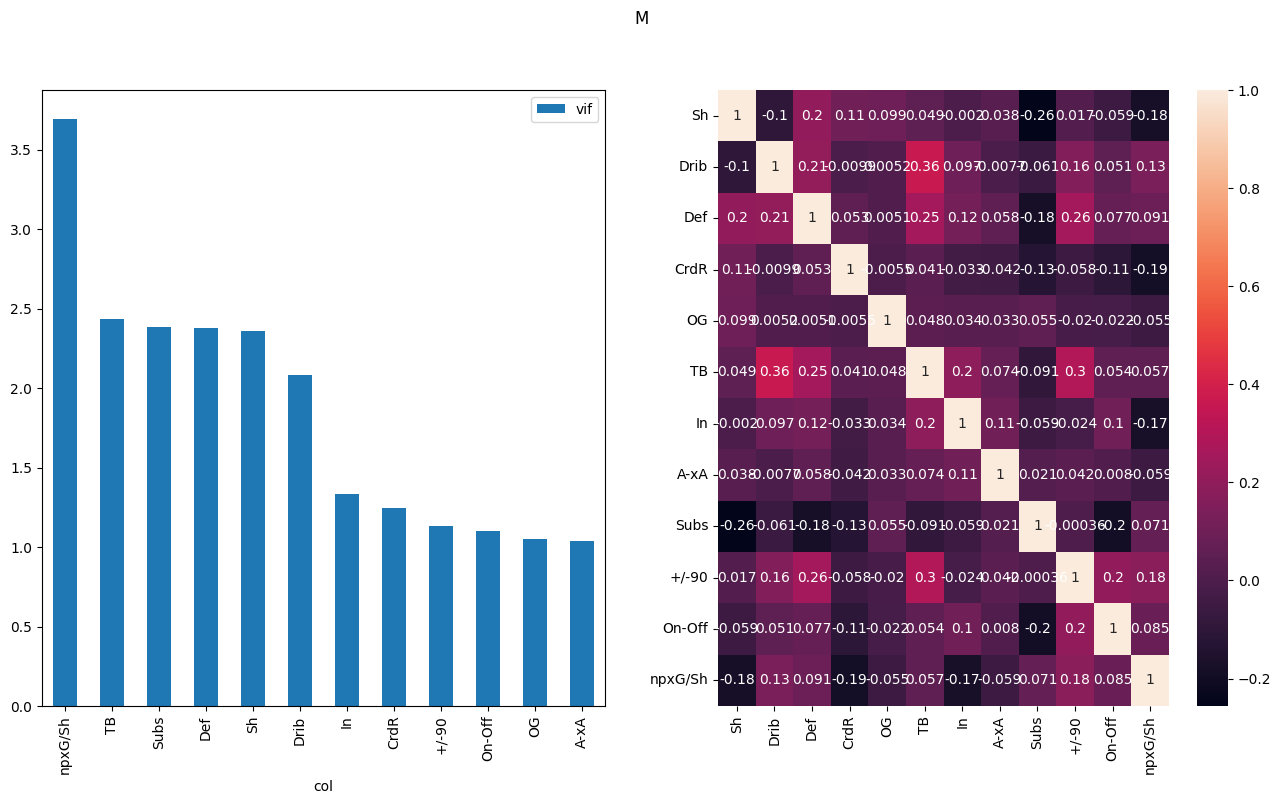

In [ ]:
role = 'M'
curr_y_non_gk = df_dataset_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), cols_y[0]]

df_vif_non_gk = df_dataset_non_gk[df_metadata_non_gk['Pos'].str.startswith(role)]
df_vif_non_gk = df_vif_non_gk.drop(cols_y[0], axis=1)
df_vif_non_gk[cols_y[0]] = curr_y_non_gk
cols_non_gk_sfs = [col for col in dict_sfs[role].get_support()] + [False]
df_vif_non_gk = df_vif_non_gk.iloc[:, cols_non_gk_sfs]
cols_vif_non_gk_ko = ['npxG+xA', 'Mn/MP', 'onGA', 'Head', 'PassDead', 'PPM',
                      'SCA90', 'Recov', 'G+A', 'Age', 'onxGA', 'KP', 'Dis',
                      'Gls', 'unSub', '#Pl', 'Clr', 'npxG', 'GCA', 'CK', 'Tkl%',
                      'Left', 'Other', 'CPA', 'Att 3rd', 'Lost', 'FK', 'Crs'
                      ]
# cols_vif_non_gk_ko = ['G+A', 'Age', 'npxG', 'GCA', '#Pl', 'Head', 'PassDead',
#                       'npxG/Sh', 'FK',
#                       # 'Att 3rd',
#                       'Left']
# cols_vif_non_gk_ko = ['G+A', 'Age', 'npxG', 'GCA', '#Pl', 'Head', 'PassDead', 'FK']
df_vif_non_gk = df_vif_non_gk.drop(cols_vif_non_gk_ko, axis=1)
vif_non_gk = calculate_vif(df_vif_non_gk, col_y=cols_y[0])

dict_vif_non_gk[role] = df_vif_non_gk

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
vif_non_gk.sort_values('vif', ascending=False)\
  .plot(kind='bar', x='col', y='vif', ax=axes[0])
corrs_non_gk = df_vif_non_gk.corr(method='spearman')
sns.heatmap(corrs_non_gk, annot=True, ax=axes[1])
plt.suptitle(role)

Text(0.5, 0.98, 'F')

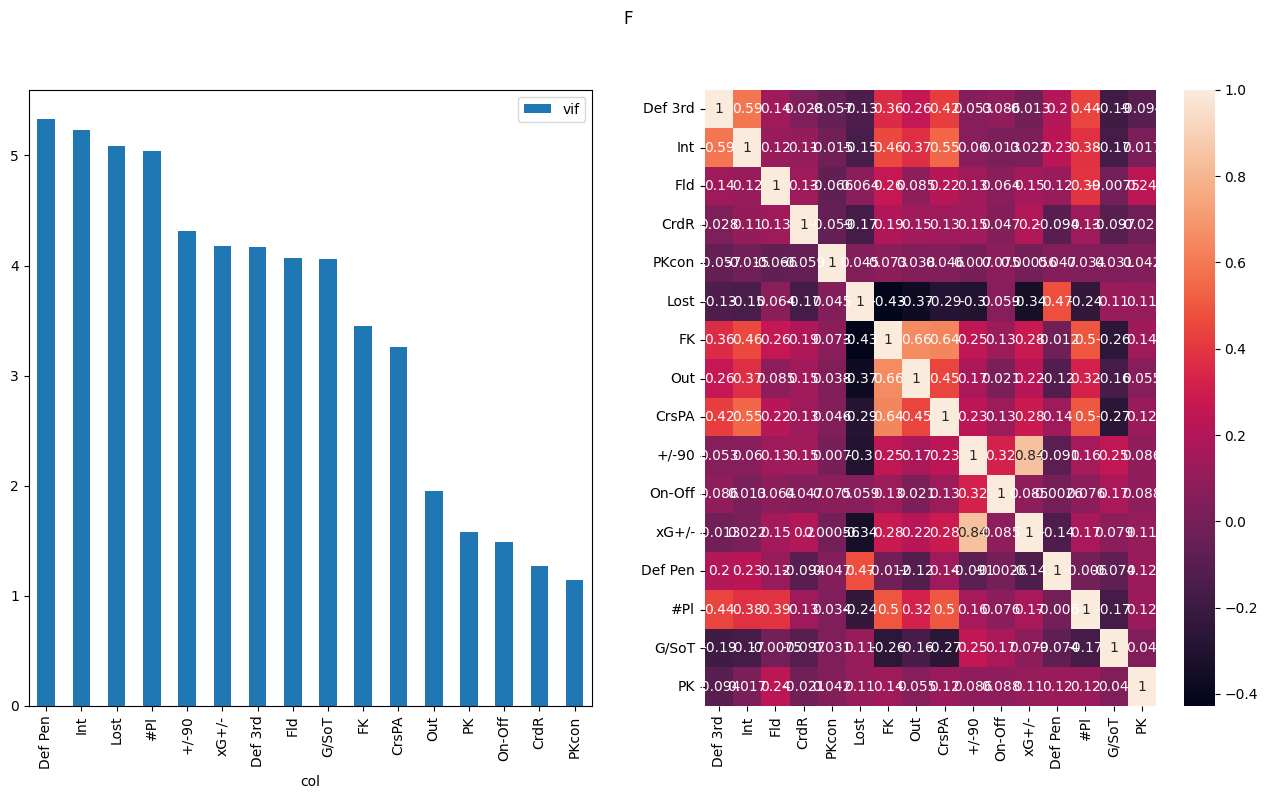

In [ ]:
role = 'F'
curr_y_non_gk = df_dataset_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), cols_y[0]]

df_vif_non_gk = df_dataset_non_gk[df_metadata_non_gk['Pos'].str.startswith(role)]
df_vif_non_gk = df_vif_non_gk.drop(cols_y[0], axis=1)
df_vif_non_gk[cols_y[0]] = curr_y_non_gk
cols_non_gk_sfs = [col for col in dict_sfs[role].get_support()] + [False]
df_vif_non_gk = df_vif_non_gk.iloc[:, cols_non_gk_sfs]
cols_vif_non_gk_ko = ['G+A', 'Min', 'Targ', 'Rec%', 'Cmp%', 'PPM', 'PassLive',
                      'onxGA', 'Recov', 'G+A-PK', 'PKatt', 'Ground', 'SCA90',
                      'Succ', 'Subs', 'xA', 'SoT', 'Pass', 'SoT%', 'Head', 'Past',
                      'GCA', 'Mn/Start', 'Right'
                      ]
# cols_vif_non_gk_ko = ['Rec%', 'onxGA', 'PKatt', 'G+A', 'Succ', 'SoT%', 'Past',
#                       'xA', 'Def Pen']
# cols_vif_non_gk_ko = ['onxGA', 'PKatt', 'Succ', 'Rec%', 'Def 3rd', 'G+A']
df_vif_non_gk = df_vif_non_gk.drop(cols_vif_non_gk_ko, axis=1)
vif_non_gk = calculate_vif(df_vif_non_gk, col_y=cols_y[0])

dict_vif_non_gk[role] = df_vif_non_gk

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
vif_non_gk.sort_values('vif', ascending=False)\
  .plot(kind='bar', x='col', y='vif', ax=axes[0])
corrs_non_gk = df_vif_non_gk.corr(method='spearman')
sns.heatmap(corrs_non_gk, annot=True, ax=axes[1])
plt.suptitle(role)

# Model Inference

Now that the datasets are ready, we can build the models telling us what's the impact of each feature on the output variable.

In [ ]:
def infere_model(df, cols_x, col_y):
  """
  Train a linear regression model.

  Args
      df (pandas.DataFrame): complete input dataset
      cols_x (list): names of independent variables to be kept
      col_y (str): name of dependent variable

  Returns
      model_fit (statsmodels.OLS): trained model
      results (OLSResults): regression results
  """
  x = df[[col for col in cols_x]]
  y = df[col_y].values

  x = sm.add_constant(x)
  ols = sm.OLS(y, x)
  model_fit = ols.fit_regularized(method='elastic_net',
                                  start_params=ols.fit().params)
  results = sm.regression.linear_model.OLSResults(ols,
                                                  model_fit.params,
                                                  ols.normalized_cov_params)
  return model_fit, results


def plot_linear_regression_assumptions(x, y, model_fit):
  """
  Plot graphs showing linear regression assumptions:
  1. Linearity of actuals VS predictions
  2. Residuals' normal distribution
  3. Residuals' variance

  Args
      x (numpy.array): independent variables
      y (numpy.array): dependent variable
      model_fit (statsmodels.OLS): trained linear regression model

  Returns
      None
  """
  # Add constant to x
  x = sm.add_constant(x)

  # Predictions
  y_pred = model_fit.predict(x)
  errors = y - y_pred

  # Plot
  # fig = plt.figure(figsize=(16, 6))
  # 1 – Linearity
  plt.subplot(1, 3, 1)
  plt.scatter(y, y_pred)
  plt.xlabel("Actuals")
  plt.ylabel("Predictions")
  plt.title("Linear Assumption")
  # 2 – Residuals distributions
  plt.subplot(1, 3, 2)
  sns.histplot(errors)
  # sns.displot(errors)
  # sns.distplot(errors)
  plt.title("Residuals Distribution")
  # 3 – Residuals variance
  plt.subplot(1, 3, 3)
  plt.scatter(range(len(errors)), errors)
  plt.title("Residuals")

## Train Models

For each position, a linear regression model is trained.



In [ ]:
# GK
df_curr = df_vif_gk.copy()
curr_x_cols = df_curr.columns
df_curr[cols_y[0]] = y_gk
model_gk, results_gk = infere_model(df_curr,
                                    curr_x_cols,
                                    cols_y[0])

In [ ]:
# Non-GK
dict_models, dict_results = {}, {}

for role in dict_vif_non_gk.keys():
  df_curr = dict_vif_non_gk[role].copy()
  curr_x_cols = df_curr.columns
  df_curr[cols_y[0]] = \
    df_dataset_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), cols_y[0]].values

  model_non_gk, results_non_gk = infere_model(df_curr,
                                              curr_x_cols,
                                              cols_y[0])
  dict_models[role] = model_non_gk
  dict_results[role] = results_non_gk

## Display Results

### Model Summary

We can now examine the details of each model to gather information about the variables that affect the performance of each role.  

To do so, we examine the following elements:
- `P>|t|` – This is the p-value, representing the probability that the results occurred by chance. In this case, we only look at variables with a value lower than 0.05.
- `coef` – It represents how much the output will change if an individual variable changes of 1 unit, while keeping the rest of the features constant.

For each data segment (i.e. for each position of the pitch), we will highlight the variables that show the highest absolute coefficients and a p-value lower than 0.05, plus the potential gain (or loss) in the average yearly fantasy score in case the variable increased its value.

In [ ]:
results_gk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     10.31
Date:                Mon, 14 Aug 2023   Prob (F-statistic):           2.47e-08
Time:                        13:32:21   Log-Likelihood:                 70.574
No. Observations:                  83   AIC:                            -127.1
Df Residuals:                      76   BIC:                            -110.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3767      0.053    119.919      0.000       6.271       6.483
OG            -0.0079      0.009     -0.858      0.393      -0.026       0.010
PSxG+/-        0.0169      0.003      6.077      0.000       0.011       0.022
Stp%          -0.0145      0.005     -3.097      0.003      -0.024      -0.005
#OPA/90       -0.0393      0.047     -0.835      0.406      -0.133       0.054
W             -0.0065      0.002     -2.890      0.005      -0.011      -0.002
PKsv           0.0281      0.013      2.227      0.029       0.003       0.053
==============================================================================
Omnibus:                        0.764   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.683   Jarque-Bera (JB):                0.884
Skew:                           0.173   Prob(JB):                        0.643
Kurtosis:                       2.631   Cond. No.                         69.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For the role of **goalkeeper**, these are the relevant variables that affect the performance:
- `PKsv` – Penalty Kicks Saved.
  - +0.1 points every 3.5 units.
- `PSxG+/-` – Post-Shot Expected Goals minus Goals Allowed. Positive numbers suggest better luck or an above average ability to stop shots.
  - +0.1 points every 6 units.
- `Stp%` – Percentage of crosses into penalty area which were successfully stopped by the goalkeeper.
  - -0.1 points every 7 units.  
  
As expected, the ability to save penalty kicks allows goalkeepers to boost their performance.  
`PSxG+/-` has also been one of the most informative metrics to judge how capable a goalkeeper can be.  
Finally, the negative impact of `Stp%` could be attributed to some underlying confounding factors.

In [ ]:
dict_results['D'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     35.66
Date:                Mon, 14 Aug 2023   Prob (F-statistic):           3.03e-77
Time:                        13:08:56   Log-Likelihood:                 259.80
No. Observations:                 436   AIC:                            -477.6
Df Residuals:                     415   BIC:                            -392.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8515      0.029    204.536      0.000       5.795       5.908
Past        4.577e-05      0.001      0.067      0.946      -0.001       0.001
ShSv           0.0233      0.014      1.667      0.096      -0.004       0.051
Err           -0.0082      0.007     -1.155      0.249      -0.022       0.006
PassDead       0.0007      0.002      0.341      0.734      -0.003       0.005
Drib           0.0163      0.005      3.612      0.000       0.007       0.025
CrdY          -0.0052      0.003     -1.787      0.075      -0.011       0.001
CrdR          -0.0364      0.012     -3.127      0.002      -0.059      -0.014
Off           -0.0003      0.004     -0.072      0.942      -0.008       0.007
PKwon          0.0353      0.019      1.883      0.060      -0.002       0.072
OG            -0.0480      0.017     -2.778      0.006      -0.082      -0.014
Won            0.0012      0.000      3.344      0.001       0.000       0.002
Str            0.0004      0.009      0.045      0.964      -0.017       0.018
unSub         -0.0053      0.001     -3.791      0.000      -0.008      -0.003
+/-90          0.1501      0.016      9.200      0.000       0.118       0.182
On-Off         0.0051      0.011      0.479      0.632      -0.016       0.026
xG+/-          0.0001      0.001      0.126      0.900      -0.002       0.002
Mn/Sub        -0.0011      0.000     -2.448      0.015      -0.002      -0.000
Gls            0.0303      0.006      5.041      0.000       0.018       0.042
SoT%           0.0009      0.000      2.224      0.027       0.000       0.002
PKatt         -0.0069      0.014     -0.481      0.630      -0.035       0.021
==============================================================================
Omnibus:                        1.541   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.611
Skew:                           0.110   Prob(JB):                        0.447
Kurtosis:                       2.800   Cond. No.                         242.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The assessment of **defenders**' quality seems to be affected by the following elements:
- `+/-90` – Goals scored minus goals allowed by the team while the player was on the pitch per 90 minutes played.
  - +0.15 points every 1 unit.
- `OG` – Own goals.
  - -0.1 points every 2 units.
- `CrdR` – Red cards.
  - -0.1 points every 2.7 units.
- `Gls` – Goals scored.
  - +0.1 points every 3.3 units.
- `Drib` – Successful dribbles that lead to a shot attempt.
  - +0.1 points every 6 units.  
  
`+/-90` seems like a robust metric able to capture a lot of information concisely. For a defender, it is likely that the higher this difference is, the lower the number of allowed goals.
Dribblings leading to shots and goals scored are two more variables positively impacting a player's score.  
Not surprisingly, two expected penalizing features are own goals and red cards.  

In [ ]:
dict_results['M'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     39.52
Date:                Mon, 14 Aug 2023   Prob (F-statistic):           6.81e-57
Time:                        13:38:26   Log-Likelihood:                 215.46
No. Observations:                 347   AIC:                            -404.9
Df Residuals:                     334   BIC:                            -354.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8546      0.028    209.019      0.000       5.799       5.910
Sh             0.0051      0.002      2.866      0.004       0.002       0.009
Drib           0.0207      0.003      7.793      0.000       0.015       0.026
Def            0.0042      0.006      0.710      0.478      -0.007       0.016
CrdR          -0.0318      0.013     -2.481      0.014      -0.057      -0.007
OG            -0.0450      0.034     -1.323      0.187      -0.112       0.022
TB             0.0094      0.003      2.838      0.005       0.003       0.016
In             0.0027      0.001      3.369      0.001       0.001       0.004
A-xA           0.0160      0.005      3.007      0.003       0.006       0.026
Subs          -0.0075      0.002     -4.037      0.000      -0.011      -0.004
+/-90          0.1205      0.010     11.791      0.000       0.100       0.141
On-Off         0.0176      0.011      1.634      0.103      -0.004       0.039
npxG/Sh        0.4684      0.222      2.107      0.036       0.031       0.906
==============================================================================
Omnibus:                        0.411   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.814   Jarque-Bera (JB):                0.222
Skew:                           0.022   Prob(JB):                        0.895
Kurtosis:                       3.116   Cond. No.                         370.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Midfielders** are mostly judged by these attributes:
- `npxG/Sh` – Non-Penalty Expected Goals per shot.
  - +0.46 points every 1 unit.
- `+/-90` – Plus/Minus per 90 Minutes. Goals scored minus goals allowed by the team while the player was on the pitch per 90 minutes played.
  - +0.1 point every 1 unit.
- `CrdR` – Red cards.
  - -0.1 points every 3 units.
- `Drib` – Successful dribbles that lead to a shot attempt.
  - +0.1 points every 5 units.
- `A-xA` – Assists minus xG assisted.
  - +0.1 points every 6 units.

Most of the mentioned variables associated with a positive gain in performance seem correlated with offensive actions:
- `npxG/Sh` quantifies how dangerous the player's average shot is.
- `Drib` measures the ability to create numerical superiority or reach more dangerous positions.
- `A-xA` estimates the quality of a player's assisting precision.  
  
`+/-90` is the only variable with a positive impact on the output that can be useful both for offensive- and defensive-leaning players. In fact, a positive value would correspond to the team prevailing on the opponents and/or conceding a low number of goals.  
  
Once again, red cards provide a negative contribution to the overall average score.

In [ ]:
dict_results['F'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     27.80
Date:                Mon, 14 Aug 2023   Prob (F-statistic):           9.52e-45
Time:                        13:23:54   Log-Likelihood:                 123.79
No. Observations:                 245   AIC:                            -213.6
Df Residuals:                     228   BIC:                            -154.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6429      0.039    145.110      0.000       5.566       5.719
Def 3rd       -0.0019      0.003     -0.740      0.460      -0.007       0.003
Int            0.0010      0.002      0.500      0.618      -0.003       0.005
Fld            0.0072      0.003      2.373      0.018       0.001       0.013
CrdR          -0.0103      0.026     -0.402      0.688      -0.061       0.040
PKcon         -0.0678      0.035     -1.962      0.051      -0.136       0.000
Lost          -0.0003      0.000     -0.791      0.430      -0.001       0.000
FK            -0.0001      0.001     -0.100      0.920      -0.003       0.002
Out            0.0045      0.002      2.379      0.018       0.001       0.008
CrsPA          0.0030      0.002      1.379      0.169      -0.001       0.007
+/-90          0.1040      0.027      3.881      0.000       0.051       0.157
On-Off         0.0409      0.016      2.539      0.012       0.009       0.073
xG+/-          0.0003      0.002      0.168      0.867      -0.003       0.003
Def Pen        0.0007      0.001      0.658      0.511      -0.001       0.003
#Pl            0.0028      0.001      5.201      0.000       0.002       0.004
G/SoT          0.6647      0.083      7.962      0.000       0.500       0.829
PK             0.0311      0.005      6.068      0.000       0.021       0.041
==============================================================================
Omnibus:                       18.584   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.570
Skew:                           0.539   Prob(JB):                     4.62e-06
Kurtosis:                       4.115   Cond. No.                         605.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

How good **forwards** are can be defined by looking at:
- `G/SoT` – Goals per shot on target.
  - +0.6 points every 1 unit.
- `+/-90` – Plus/Minus per 90 Minutes. Goals scored minus goals allowed by the team while the player was on the pitch per 90 minutes played.
  - +0.1 points every 1 unit.
- `On-Off` – 	Plus/Minus Net per 90 Minutes. Net goals per 90 minutes by the team while the player was on the pitch minus net goals allowed per 90 minutes by the team while the player was off the pitch.
  - +0.1 points every 2.4 units
- `PK` – Penalty Kicks scored.
  - +0.1 points every 3 units.
  
It's no shock to learn that strikers that can score with higher precision are rewarded with a higher score at the end of the season.  
`+/-90` and `On-Off` quantify the impact that the presence of the player on the pitch has on the team's final score.  
Finally, the number of successful penalty kicks not only contribute to the total tally of goals scored during the campaign; they also suggest that the player can take the responsibility of handling such delicate moments for the whole team.

## Plot Linear Regression Assumptions

These graphs show how well the results follow the linear regression assumptions:
1. Linearity of actuals VS predictions
2. Residuals' normal distribution
3. Residuals' variance

Text(0.5, 0.98, 'GK')

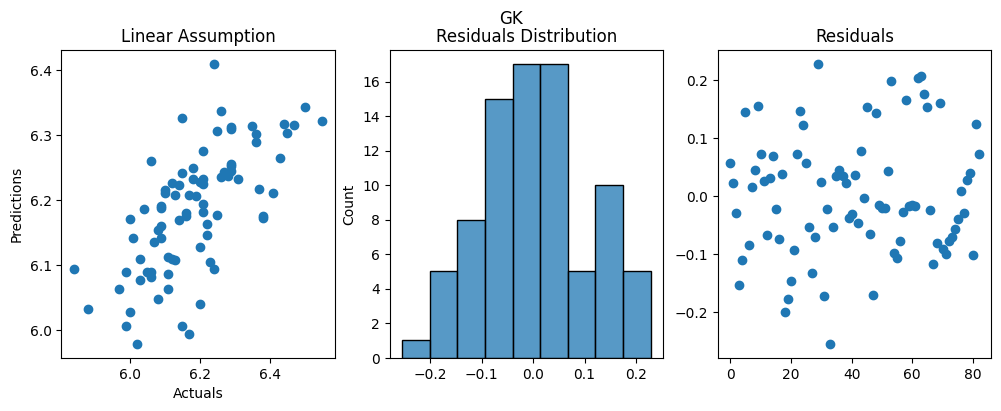

In [ ]:
plt.figure(figsize=(12, 4))
plot_linear_regression_assumptions(df_vif_gk.values, y_gk, model_gk)
plt.suptitle("GK")

Text(0.5, 0.98, 'D')

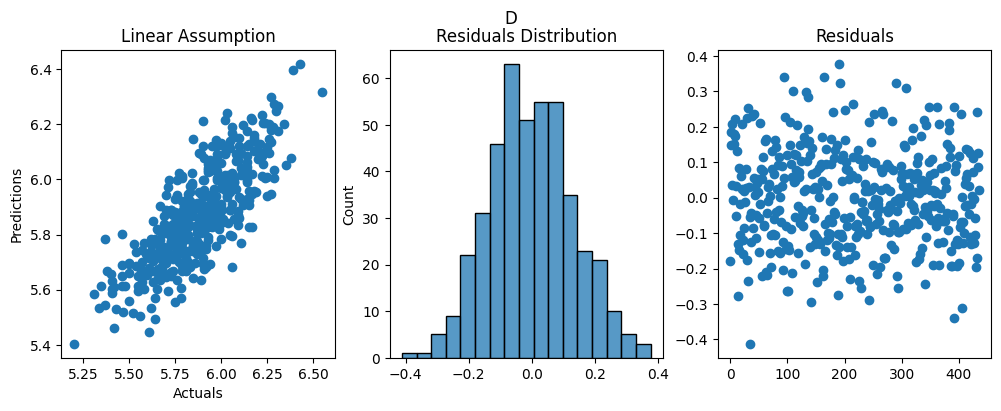

In [ ]:
role = 'D'

plt.figure(figsize=(12, 4))
y_d = df_dataset_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), cols_y[0]].values
plot_linear_regression_assumptions(dict_vif_non_gk[role].values, y_d, dict_models[role])
plt.suptitle(role)

Text(0.5, 0.98, 'M')

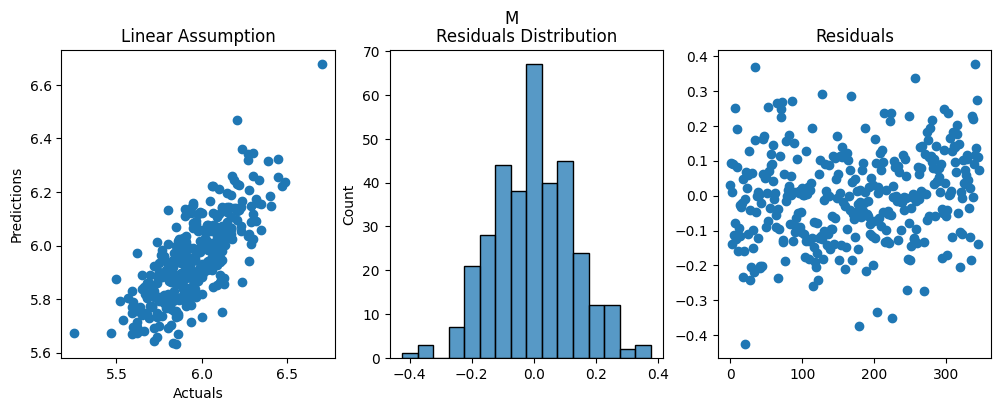

In [ ]:
role = 'M'

plt.figure(figsize=(12, 4))
y_d = df_dataset_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), cols_y[0]].values
plot_linear_regression_assumptions(dict_vif_non_gk[role].values, y_d, dict_models[role])
plt.suptitle(role)

Text(0.5, 0.98, 'F')

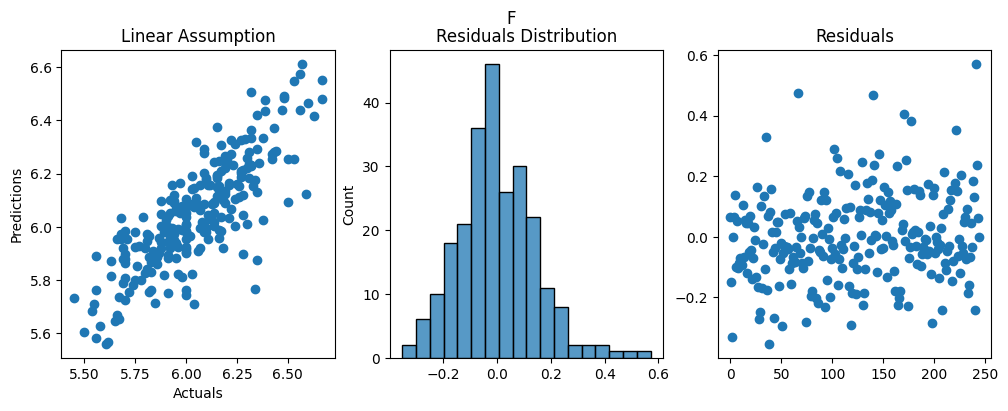

In [ ]:
role = 'F'

plt.figure(figsize=(12, 4))
y_d = df_dataset_non_gk.loc[df_metadata_non_gk['Pos'].str.startswith(role), cols_y[0]].values
plot_linear_regression_assumptions(dict_vif_non_gk[role].values, y_d, dict_models[role])
plt.suptitle(role)